In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [18]:
#定义变量
thermal_power_station_strategy=np.zeros(shape=(54,1000)) 
wind_power_station_strategy=np.zeros(shape=(6,1000))
thermal_power_station_dual_variable=np.zeros(shape=(54,1000))
wind_power_station_dual_variable=np.zeros(shape=(6,1000))
E=np.loadtxt("IEEE-118-doubly-stochastic-weight-matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))#总发电量
#火力发电站的相关数据  其中54号为拜占庭
generator_a_values= np.loadtxt("./real-data/generator_a_values.txt")#每个agent的成本函数中的超参数a
generator_b_values= np.loadtxt("./real-data/generator_b_values.txt")#每个agent的成本函数中的超参数a
generator_c_values= np.loadtxt("./real-data/generator_c_values.txt")#每个agent的成本函数中的超参数a
thermal_power_station_P_max= np.loadtxt("./real-data/generator_Pmax_values.txt")#每个agent的资源量的上界
thermal_power_station_P_min= np.loadtxt("./real-data/generator_Pmin_values.txt")#每个agent的资源量的下界
#55 56 57 58 59 60号诚实风能的成本相关数据 其中58号为拜占庭 
wind_power_station_varphi=[1,6,1,6,1,6]
wind_power_station_v_in=[3,4,5,3,4,5]
wind_power_station_v_out=[25,45,25,45,25,45]
wind_power_station_v_r=[13,15,16,13,15,16]
wind_power_station_sigma_ue=[3,5,3,5,3,5]
wind_power_station_sigma_oe=[20,30,20,30,20,30]
wind_power_station_P_r=[150,160,150,160,150,160]
wind_power_station_P_min=[0,0,0,0,0,0]
wind_power_station_P_max=[500,300,400,200,300,200]
#不确定性的参数 时变参数
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(100,10).txt") #时变的需求侧用电需求  
c_wind_speed= np.loadtxt("./real-data/weibull_scale_c.txt")      
kappa_wind_speed= np.loadtxt("./real-data/weibull_shape_wk.txt") 
#迭代步长
step_size_primal=5
step_size_dual=5
#正则化参数
regularization_parameter=0.00001

large_Gaussian_Byzantine_attack=np.loadtxt("./data/large_Gaussian_Byzantine_attack_(-500,30).txt")

In [19]:
#变量初始化
#火力，风力发电策略初始化 诚实
'''for i in range(0,53):
    thermal_power_station_strategy[i][0]=0
for j in range(0,6):
    if j!=3:
        wind_power_station_strategy[j][0]=0'''
for i in range(0,53):
    thermal_power_station_strategy[i][0]=thermal_power_station_P_max[i]
for j in range(0,6):
    if j!=3:
        wind_power_station_strategy[j][0]=thermal_power_station_P_max[j]
        
#拜占庭发电站发电策略初始化 拜占庭
thermal_power_station_strategy[53][0]=0
wind_power_station_strategy[3][0]=0
#诚实用户的初始总发电策略
'''sum_thermal_wind_power_station_strategy[0][0]=0'''
#诚实用户的初始总发电策略
for i in range(0,53):
    sum_thermal_wind_power_station_strategy[0][0]+=thermal_power_station_strategy[i][0]
for j in range(0,6):
    if j!=3:
        sum_thermal_wind_power_station_strategy[0][0]+= wind_power_station_strategy[j][0]

#火力，风力对偶策略初始化 诚实
for i in range(0,53):
    thermal_power_station_dual_variable[i][0]=-1000
for j in range(0,6):
    if j!=3:
        wind_power_station_dual_variable[j][0]=-1000
#拜占庭发电站对偶策略初始化 拜占庭
#拜占庭发电站对偶策略初始化 拜占庭
thermal_power_station_dual_variable[53][0]=large_Gaussian_Byzantine_attack[0]
wind_power_station_dual_variable[3][0]=large_Gaussian_Byzantine_attack[0]

#安全发电站的初始总发电成本 诚实
#火力发电成本
for i in range(0,53):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+generator_c_values[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+generator_b_values[i]*thermal_power_station_strategy[i][0]+generator_a_values[i]
#风力发电成本
for i in range(0,6):
    if i!=3:
        wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

#计算每个发电站的邻居发电站
neighbor_robust1_help=[]
for i in range (0,60):
    for j in range (0,60):
        if E[i][j]!=0:
            neighbor_robust1_help.append(j)
        elif E[i][j]==0:
            neighbor_robust1_help.append(99)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(60,60)

#计算安全的发电站的拜占庭邻居用户数量
q_robust1=[]
for i in range(0,60):
    q_robust1_help=0
    for j in range(0,60):
        if neighbor_robust1[i][j]==53 or neighbor_robust1[i][j]==57:
            q_robust1_help=q_robust1_help+1
    q_robust1.append(q_robust1_help)

In [20]:
def IOS_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,generator_a_values,generator_b_values,generator_c_values,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************large_attack_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,52):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,6):
        if i!=3:
            print("第",(i+55),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,52):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,6):
        if i!=3:
            print("第",(i+55),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(54),"个受到Byzantin攻击的火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[53][0])
    print("第",(58),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[3][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        dual_variable_intermediate=[] #存放当前迭代中60个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,53):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/60)*thermal_power_station_strategy[i][k-1]-(1/60)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        #添加拜占庭火力发电站的对偶值
        dual_variable_intermediate.append(large_Gaussian_Byzantine_attack[k])
        for j in range(0,6):
            if j==3: #添加拜占庭风力发电站的对偶值
                dual_variable_intermediate.append(large_Gaussian_Byzantine_attack[k])
            else:
                dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/60)*wind_power_station_strategy[j][k-1]-(1/60)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        
        #IOS鲁棒聚合+adaptive clipping 安全的火力发电站的对偶更新
        #在做鲁棒聚合前 对收集到的信息进行adaptive clipping的剪裁操作
        for i in range (0,53):
            u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
            u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
            u_neighbor_help_robust1.remove(99)
            if int(q_robust1[i])==1: #只有具有拜占庭邻居的用户才需要先进行adaptive clipping和后续的IOS聚合操作
                #先进行adaptive clipping
                dual_variable_intermediate_auxiliary=[]
                #注意必须以这样的方式赋值 不能直接写dual_variable_intermediate_auxiliary=dual_variable_intermediate
                #不然在修改变量dual_variable_intermediate_auxiliary的同时也会对dual_variable_intermediate进行修改
                for j in range(len(dual_variable_intermediate)): 
                    dual_variable_intermediate_auxiliary.append(dual_variable_intermediate[j])
                dual_variable_receive=[]
                clipping_C=0
                for j in range(0, len(u_neighbor_help_robust1)):
                    dual_variable_receive.append(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])
                dual_variable_receive.sort()
                clipping_C=-dual_variable_receive[1] #确定clpping的阈值
                #接下来对大于clipping_C的值进行clipping
                for j in range(0, len(u_neighbor_help_robust1)):
                    if -dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]>clipping_C:
                        dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]=-clipping_C
                #接下来做IOS鲁棒聚合
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的h值
                    h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的对偶权重平均值
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])
                #剔除一个对偶值离权重平均对偶值最远的用户 保留自身的值
                u_neighbor_help_robust1.remove(i)
                neighbor_index_robust1=u_neighbor_help_robust1[0]
                max_distance_roubust1=abs(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[0]]-dual_variable_weight_average_robust1)
                for j in range(1,len(u_neighbor_help_robust1)):
                    if abs(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]-dual_variable_weight_average_robust1)>=max_distance_roubust1:
                        max_distance_roubust1=abs(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]-dual_variable_weight_average_robust1)
                        neighbor_index_robust1=u_neighbor_help_robust1[j]
                u_neighbor_help_robust1.remove(neighbor_index_robust1)
                u_neighbor_help_robust1.append(i)
                #计算剔除q个信息后的权重平均对偶值
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):
                    h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
                for j in range(0,len(u_neighbor_help_robust1)):
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])     
                #诚实用户基于IOS鲁棒聚合后的值进行自身的对偶变量的更新 基于权重平均值
                thermal_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1              
            else: #没有拜占庭邻居的用户直接进行权重聚合即可
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的h值
                    h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
                for j in range(0,len(u_neighbor_help_robust1)):
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]]) 
                    #dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]])                  
                #诚实用户基于IOS鲁棒聚合后的值进行自身的对偶变量的更新 基于权重平均值
                thermal_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1  
                #thermal_power_station_dual_variable[i][k]=9999

        #安全的风力发电站的adaptive clipping操作 由于风力发电站的邻居中没有拜占庭用户 所以不需要进行adaptive clipping的操作
        #聚合 安全的风力发电站的对偶更新
        for i in range(0,6):
            if i!=3:
                u_neighbor_help_robust1=neighbor_robust1[i+54].tolist()#将用户i的邻居序号存在辅助变量u中
                u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
                u_neighbor_help_robust1.remove(99)
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):
                    h_robust1=h_robust1+E[i+54][u_neighbor_help_robust1[j]]               
                for j in range(0,len(u_neighbor_help_robust1)):
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i+54][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]])     
                wind_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1
        
        #受到Byzantine攻击的火力和风力发电站的对偶更新
        thermal_power_station_dual_variable[53][k]=large_Gaussian_Byzantine_attack[k]
        wind_power_station_dual_variable[3][k]=large_Gaussian_Byzantine_attack[k]            
        
        #安全的火力发电站计划发电量
        for i in range(0,53):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*generator_c_values[i]*thermal_power_station_strategy[i][k-1]+generator_b_values[i]+(1/60)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,6):
            if i!=3:
                wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/60)*wind_power_station_dual_variable[i][k-1])
                if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                    wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
                elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                    wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的火力和风力发电站的计划发电量
        thermal_power_station_strategy[53][k]=thermal_power_station_strategy[53][k-1]
        wind_power_station_strategy[3][k]=wind_power_station_strategy[3][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,53):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,6):
            if i!=3:
                sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,53):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+generator_c_values[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+generator_b_values[i]*thermal_power_station_strategy[i][k]+generator_a_values[i]
        #风力发电成本
        for i in range(0,6):
            if i!=3:
                wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        if (k+1)%10==0:
        #if k<=5:
            print(k,"次迭代中的结果：")
            for i in range (0,53):
                print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
            for i in range (0,6):
                if i!=3:
                    print("第",(i+55),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
            print("****************************************************************************")
            for i in range (0,53):
                print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
            for i in range (0,6):
                if i!=3:
                    print("第",(i+55),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
            print("****************************************************************************")
            print("第",(54),"个受到Byzantin攻击的火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[53][k])
            print("第",(58),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[3][k])
            print("****************************************************************************")
            print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
            print("*************************")
            print("需求侧平均用电需求:",d_power_demand[k])
            print("****************************************************************************")
            print("风速分布参数c:",c_wind_speed[k])
            print("****************************************************************************")
            print("风速分布参数kappa:",kappa_wind_speed[k])
            print("****************************************************************************")        
            print("安全发电站的总发电成本：", sum_cost[0][k])
            print("****************************************************************************")
            print("原变量迭代步长为:",step_size_primal)
            print("****************************************************************************")
            print("对偶变量迭代步长为:",step_size_dual)
            print("****************************************************************************")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [21]:
IOS_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,generator_a_values,generator_b_values,generator_c_values,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************large_attack_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 30.0
第 2 个火力发电站的初始计划发电量为: 30.0
第 3 个火力发电站的初始计划发电量为: 30.0
第 4 个火力发电站的初始计划发电量为: 300.0
第 5 个火力发电站的初始计划发电量为: 300.0
第 6 个火力发电站的初始计划发电量为: 30.0
第 7 个火力发电站的初始计划发电量为: 100.0
第 8 个火力发电站的初始计划发电量为: 30.0
第 9 个火力发电站的初始计划发电量为: 30.0
第 10 个火力发电站的初始计划发电量为: 300.0
第 11 个火力发电站的初始计划发电量为: 350.0
第 12 个火力发电站的初始计划发电量为: 30.0
第 13 个火力发电站的初始计划发电量为: 30.0
第 14 个火力发电站的初始计划发电量为: 100.0
第 15 个火力发电站的初始计划发电量为: 30.0
第 16 个火力发电站的初始计划发电量为: 100.0
第 17 个火力发电站的初始计划发电量为: 30.0
第 18 个火力发电站的初始计划发电量为: 30.0
第 19 个火力发电站的初始计划发电量为: 100.0
第 20 个火力发电站的初始计划发电量为: 250.0
第 21 个火力发电站的初始计划发电量为: 250.0
第 22 个火力发电站的初始计划发电量为: 100.0
第 23 个火力发电站的初始计划发电量为: 100.0
第 24 个火力发电站的初始计划发电量为: 200.0
第 25 个火力发电站的初始计划发电量为: 200.0
第 26 个火力发电站的初始计划发电量为: 100.0
第 27 个火力发电站的初始计划发电量为: 420.0
第 28 个火力发电站的初始计划发电量为: 420.0
第 29 个火力发电站的初始计划发电量为: 300.0
第 30 个火力发电站的初始计划发电量为: 80.0
第 31 个火力发电站的初始计划发电量为: 30.0
第 32 个火力发电站的初始计划发电量为: 30.0
第 33 个火力发

239 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 177.4251183732055
第 5 个火力发电站的计划发电量为: 246.83716649496404
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 25.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 271.7067840300337
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 37.848429263676536
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 25.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 25.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 25.0
第 23 个火力发电站的计划发电量为: 25.0
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 25.0
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 344.87057225394636
第 29 个火力发电站的计划发电量为: 218.79188611080298
第 30 个火力发电站的计划发电量为: 36.782631597611555
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 34.28870633438602
第 35 个火力发电站的计划发电量为: 25.0
第 36 个火力发电站的计划发电量为

499 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 183.84205509971397
第 5 个火力发电站的计划发电量为: 254.38358818871882
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 25.019734164761527
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 278.83737762537294
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 44.299130595635745
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 25.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 25.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 25.0
第 23 个火力发电站的计划发电量为: 25.0
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 25.0
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 353.39695590431916
第 29 个火力发电站的计划发电量为: 226.53541084425962
第 30 个火力发电站的计划发电量为: 39.16585626300259
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 40.455095489123124
第 35 个火力发电站的计划发电量为: 25.0
第 

第 60 个风力发电站的计划发电量为: 32.42467134796382
****************************************************************************
第 1 个火力发电站的对偶变量为: -1140.3542543906083
第 2 个火力发电站的对偶变量为: -1133.8462036970718
第 3 个火力发电站的对偶变量为: -1105.822402759557
第 4 个火力发电站的对偶变量为: -1017.7084494061999
第 5 个火力发电站的对偶变量为: -1111.8800392698163
第 6 个火力发电站的对偶变量为: -1111.7618456298046
第 7 个火力发电站的对偶变量为: -1112.5177103539345
第 8 个火力发电站的对偶变量为: -1133.8046988287022
第 9 个火力发电站的对偶变量为: -1156.9050589978349
第 10 个火力发电站的对偶变量为: -1143.597251589978
第 11 个火力发电站的对偶变量为: -1108.5921773123885
第 12 个火力发电站的对偶变量为: -1153.3632767332665
第 13 个火力发电站的对偶变量为: -1117.8465837007047
第 14 个火力发电站的对偶变量为: -1143.4981533330642
第 15 个火力发电站的对偶变量为: -1104.2176153142163
第 16 个火力发电站的对偶变量为: -1104.5821209489998
第 17 个火力发电站的对偶变量为: -1099.7231995398154
第 18 个火力发电站的对偶变量为: -1064.6893425956168
第 19 个火力发电站的对偶变量为: -1015.0219332226648
第 20 个火力发电站的对偶变量为: -1004.8954016767459
第 21 个火力发电站的对偶变量为: -970.5606200957334
第 22 个火力发电站的对偶变量为: -968.2231769653091
第 23 个火力发电站的对偶变量为: -968.2231769653091
第 

999 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 181.71162961741624
第 5 个火力发电站的计划发电量为: 252.02702845624418
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 25.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 276.74504853061615
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 42.39385546976891
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 25.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 25.0
第 20 个火力发电站的计划发电量为: 250.0
第 21 个火力发电站的计划发电量为: 250.0
第 22 个火力发电站的计划发电量为: 25.0
第 23 个火力发电站的计划发电量为: 25.0
第 24 个火力发电站的计划发电量为: 200.0
第 25 个火力发电站的计划发电量为: 200.0
第 26 个火力发电站的计划发电量为: 25.0
第 27 个火力发电站的计划发电量为: 420.0
第 28 个火力发电站的计划发电量为: 350.07718353533113
第 29 个火力发电站的计划发电量为: 223.97749340471597
第 30 个火力发电站的计划发电量为: 38.44224898859862
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 38.676717271588444
第 35 个火力发电站的计划发电量为: 25.0
第 36 个火力发电站的计划发电量

In [22]:
#数据存储
np.savetxt('./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [24]:
sum_cost=np.loadtxt("./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(100,10).txt")

In [25]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [26]:
dynamic_regret

[34923.03850531,
 56104.61179886,
 69458.89171172002,
 60698.06534050002,
 73161.98716884002,
 51067.63933611002,
 45488.18013458002,
 29350.985006680014,
 34513.021937880025,
 13060.935653130015,
 -10553.947277419982,
 -45330.93471828998,
 -74109.35286335998,
 -92941.58158158998,
 -123309.97369521999,
 -142488.60181679,
 -150181.29882231,
 -172477.49157897,
 -172056.49905563,
 -182656.44094961,
 -235239.30004958,
 -242905.49451497,
 -262531.35243696,
 -284864.65260232997,
 -295945.09205648,
 -313407.55982754,
 -343876.87248831004,
 -366990.12365291006,
 -389205.13437856006,
 -416510.28667333006,
 -451870.63429618004,
 -473629.96816316,
 -479787.1561026401,
 -504397.85616852005,
 -495838.0591413501,
 -525805.733708,
 -551068.69092286,
 -562370.4948560201,
 -570045.2040880101,
 -592126.1887723102,
 -613036.9700733601,
 -632765.2368204901,
 -642699.1871565401,
 -687823.0046290102,
 -711439.1323997201,
 -729825.6856760902,
 -743324.4237486601,
 -769595.2319919101,
 -799542.1170440501,
 -8

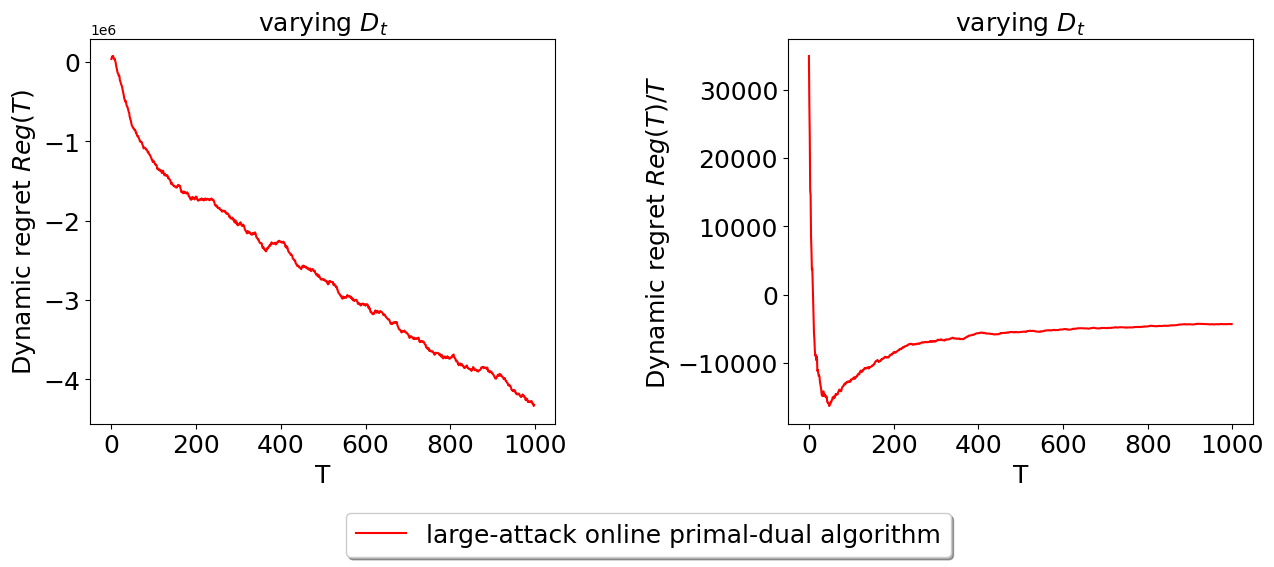

In [27]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='large-attack online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='large-attack online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [29]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(100,10).txt")

In [30]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/58)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [31]:
accumulative_constraint_violation

[31.98579342931035,
 51.18718774172413,
 63.294332376206896,
 54.977947419655194,
 67.16279319913795,
 46.652590536379336,
 41.1790433924138,
 25.864855181896544,
 31.100147820172396,
 10.736024792758599,
 11.690237549482774,
 44.15912370965519,
 71.40417447706898,
 89.6851594034483,
 118.48199673000002,
 137.17037729413795,
 145.01049310000002,
 166.61173618310346,
 166.23213587189656,
 176.94232734948275,
 225.01952318379307,
 232.8781736577586,
 252.09279600689655,
 273.7991147787931,
 284.9983528543104,
 302.2121339646552,
 331.27813330775865,
 353.68461238775865,
 375.26001152724143,
 401.4473068217242,
 434.80275263637935,
 455.9210329260345,
 462.29959519189657,
 485.9758355010345,
 477.03991080413795,
 505.4959402472414,
 529.7125457274137,
 541.0546348901723,
 548.9173846479309,
 570.1988568063791,
 590.4004394929309,
 609.5074247191378,
 619.5180356943102,
 660.8964104060344,
 683.4861690732757,
 701.3015032489653,
 714.598243201724,
 739.501755479655,
 767.6501519339653,
 77

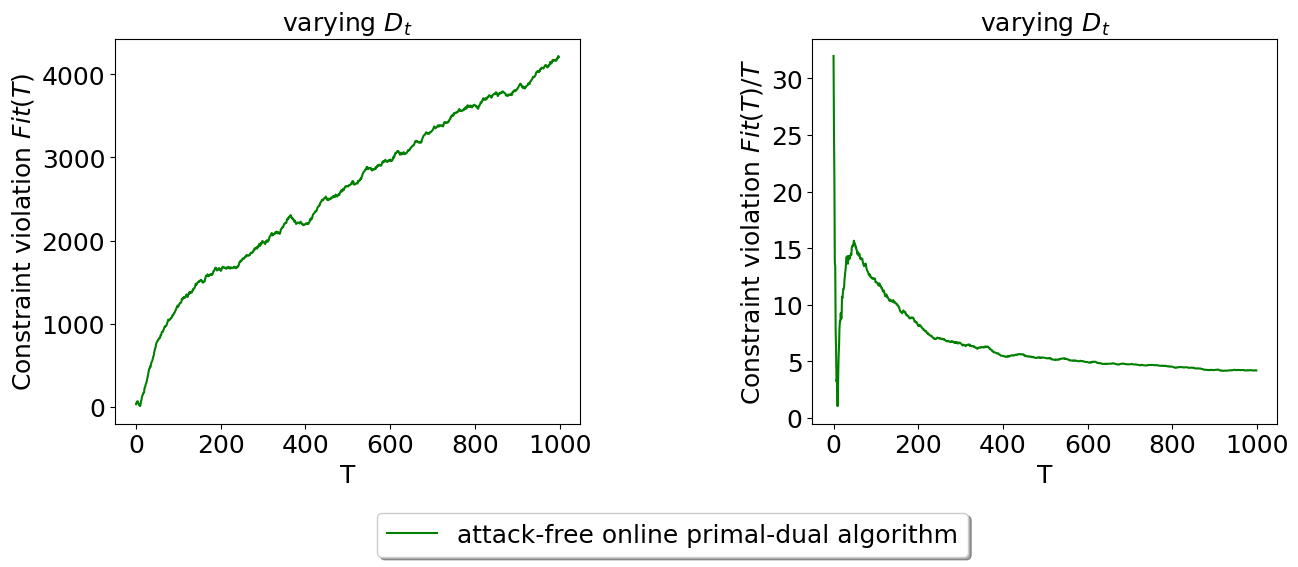

In [32]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')